# Distinguishing Sentiments

* Trend 1: In general, the quantity of positve tweets exceeded that of negative ones. Compound score goes up to 0.91, and down to -0.86.
* Trend 2: CBS has the most tweets with positive compound scores in the range above 0.70, and Fox has the least negative tweets among all.
* Trend 3: Clusters in more than five unneutral tweets appear 4+ times in the graph(CBS around 0.70 and -0.40, for example), indicating a probable similar writing style and word usage of the content creator.

In [9]:
# Dependencies
import tweepy
from pprint import pprint
import time
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
plt.style.use("dark_background")

# Twitter API Keys
from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, parser=tweepy.parsers.JSONParser())

In [10]:
# Save twitter usernames in a list
target_list = ["@BBC", "@CBS", "@CNN", "@Fox", "@nytimes"]

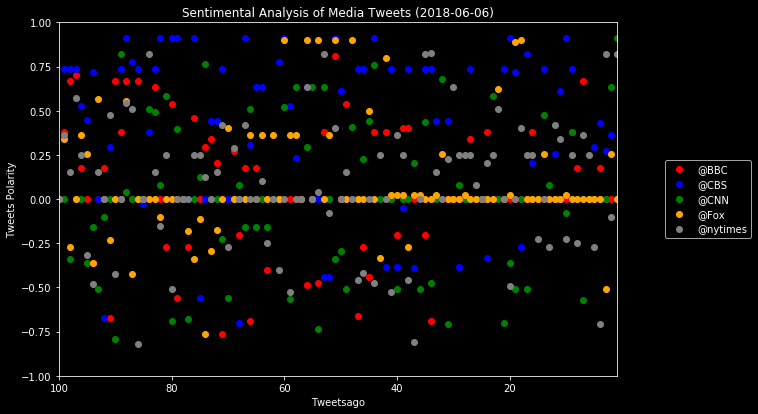

In [11]:
# Empty dataframe
df = pd.DataFrame({})

colors = ["r", "b", "g", "orange", "grey"]

plt.figure(figsize=(10,6.5))

# Loop through target list
for target in target_list:
    count = 0
    unique_ids = []
    account_list = []
    text_list = []
    date_list = []
    compound_list = []
    positive_list = []
    negative_list = []
    neutral_list = []
    oldest_tweet = None 
    
    # Loop for 5 times and get more data than needed, to get to 100 results after removing duplicates
    for i in range(5):
        tweets = api.search(target, count=100, max_id=oldest_tweet)

        # Loop through tweets
        for tweet in tweets["statuses"]:
            # Get tweet id
            tweet_id = tweet["id"]
                
            # Run sentimental analysis
            analyzer = SentimentIntensityAnalyzer()
            result = analyzer.polarity_scores(tweet["text"])   

            # Only collect 100 lines of data for each target
            if count < 100:
                # Append values to lists            
                if tweet_id not in unique_ids:
                    unique_ids.append(tweet_id)
                    account_list.append(target)
                    date = tweet["created_at"]
                    date_list.append(date)
                    text_list.append(tweet["text"])
                    compound_list.append(result["compound"])
                    positive_list.append(result["pos"])
                    negative_list.append(result["neg"])
                    neutral_list.append(result["neu"])
                    count = count + 1

            # Set the new oldest_tweet value            
            oldest_tweet = tweet["id"] - 1
    
    # Create a dataframe with sentiment analysis results
    target_df = pd.DataFrame(
    {
        "account" : account_list,
        "date" : date_list,
        "compound": compound_list,
        "positive" : positive_list,
        "negative": negative_list,
        "neutral" : neutral_list,
        "text" : text_list
    })

    # Arrange columns of the dataframe
    columns = ["account", "date", "compound", "positive", "negative", "neutral", "text"]
    target_df = target_df[columns]
    
    # Plot with data in the dataframe
    plt.plot(range(1, len(target_df)+1), target_df["compound"], linewidth=0, marker='o', color=colors[target_list.index(target)])
    df = pd.concat([df, target_df])

# Set plot styles
now = datetime.now()
now = now.strftime("%Y-%m-%d")
plt.title(f"Sentimental Analysis of Media Tweets ({now})")
plt.xlabel("Tweetsago")
plt.ylabel("Tweets Polarity")
plt.legend(target_list, loc="center right", bbox_to_anchor=(1.25, 0.5))
plt.xlim(100, 1)
plt.ylim(-1, 1)
plt.savefig("output.png")
plt.show()

In [12]:
# Export results to csv file
df.to_csv("output.csv", index=None)